# Visualization Variant Painting Images and Cells

In [1]:
import polars as pl
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from tqdm import tqdm
import re

CP_GALLERY_DIR = "../../../../2_analysis/3_cytoself/cellpainting_gallery"
batches = ["2024_01_23_Batch_7", "2024_02_06_Batch_8"]

## Loading meta data and variant classification

### Read in the meta data

In [2]:
meta_data = pl.DataFrame()
plate_map_dirs = [
    f"../snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap/" 
    for batch_id in batches
]
for plate_map_dir in plate_map_dirs:
    for plate_map in os.listdir(plate_map_dir):
        if plate_map.endswith(".txt") and plate_map.startswith("B7A1R1_P"):
            plate_map_path = os.path.join(plate_map_dir, plate_map)
            plate_map_data = pl.read_csv(plate_map_path, separator="\t", infer_schema_length=1000000)
            # print(plate_map_data)
            if meta_data.is_empty():
                meta_data = plate_map_data
            else:
                meta_data = pl.concat([meta_data, plate_map_data], how="vertical_relaxed")

display(meta_data.head())
display(meta_data.tail())

shape: (5, 30)
┌────────────────┬───────────────┬──────────────┬────────┬───┬─────┬──────┬──────┬─────────────┐
│ plate_map_name ┆ well_position ┆ control_type ┆ symbol ┆ … ┆ r96 ┆ r384 ┆ c384 ┆ r384_letter │
│ ---            ┆ ---           ┆ ---          ┆ ---    ┆   ┆ --- ┆ ---  ┆ ---  ┆ ---         │
│ str            ┆ str           ┆ str          ┆ str    ┆   ┆ i64 ┆ i64  ┆ i64  ┆ str         │
╞════════════════╪═══════════════╪══════════════╪════════╪═══╪═════╪══════╪══════╪═════════════╡
│ B7A1R1_P1      ┆ A01           ┆ disease_wt   ┆ ACSF3  ┆ … ┆ 1   ┆ 1    ┆ 1    ┆ A           │
│ B7A1R1_P1      ┆ C01           ┆ allele       ┆ ACSF3  ┆ … ┆ 2   ┆ 3    ┆ 1    ┆ C           │
│ B7A1R1_P1      ┆ E01           ┆ allele       ┆ ACSF3  ┆ … ┆ 3   ┆ 5    ┆ 1    ┆ E           │
│ B7A1R1_P1      ┆ G01           ┆ allele       ┆ ACSF3  ┆ … ┆ 4   ┆ 7    ┆ 1    ┆ G           │
│ B7A1R1_P1      ┆ I01           ┆ allele       ┆ ACSF3  ┆ … ┆ 5   ┆ 9    ┆ 1    ┆ I           │
└────────────────┴───────────────┴──────────────┴────────┴───┴─────┴──────┴──────┴─────────────┘

shape: (5, 30)
┌────────────────┬───────────────┬──────────────┬────────┬───┬─────┬──────┬──────┬─────────────┐
│ plate_map_name ┆ well_position ┆ control_type ┆ symbol ┆ … ┆ r96 ┆ r384 ┆ c384 ┆ r384_letter │
│ ---            ┆ ---           ┆ ---          ┆ ---    ┆   ┆ --- ┆ ---  ┆ ---  ┆ ---         │
│ str            ┆ str           ┆ str          ┆ str    ┆   ┆ i64 ┆ i64  ┆ i64  ┆ str         │
╞════════════════╪═══════════════╪══════════════╪════════╪═══╪═════╪══════╪══════╪═════════════╡
│ B7A1R1_P2      ┆ H24           ┆ disease_wt   ┆ MAP2K2 ┆ … ┆ 4   ┆ 8    ┆ 24   ┆ H           │
│ B7A1R1_P2      ┆ J24           ┆ allele       ┆ MAP2K2 ┆ … ┆ 5   ┆ 10   ┆ 24   ┆ J           │
│ B7A1R1_P2      ┆ L24           ┆ disease_wt   ┆ MAX    ┆ … ┆ 6   ┆ 12   ┆ 24   ┆ L           │
│ B7A1R1_P2      ┆ N24           ┆ disease_wt   ┆ MCEE   ┆ … ┆ 7   ┆ 14   ┆ 24   ┆ N           │
│ B7A1R1_P2      ┆ P24           ┆ allele       ┆ NAA10  ┆ … ┆ 8   ┆ 16   ┆ 24   ┆ P           │
└────────────────┴───────────────┴──────────────┴────────┴───┴─────┴──────┴──────┴─────────────┘

### Classification of variant

In [3]:
# trn_imbalance_thresh = 3

# Paths
metrics_dir = "../snakemake_pipeline/outputs/analyses/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect"
metrics_df, metrics_wtvar = pl.DataFrame(), pl.DataFrame()
for batch in batches:
    met_dir = metrics_dir.format(batch)
    metrics_df_batch = pl.read_csv(f"{met_dir}/metrics.csv")
    metrics_wtvar_batch = pl.read_csv(f"{met_dir}/metrics_summary.csv")

    metrics_df = pl.concat([metrics_df, metrics_df_batch])
    metrics_wtvar = pl.concat([metrics_wtvar, metrics_wtvar_batch])

## get the localization metrics
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")
## get the alleles and their reference genes
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("mislocalized")
).unique()

## get the localization metrics
morph_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "morphology")
## get the alleles and their reference genes
morph_wtvar = morph_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("morph_change")
).unique()

display(morph_wtvar.head())
display(local_wtvar.head())

# misloc_alleles = (
#     local_wtvar
#     .select("allele_0")
#     .to_series()
#     .to_list()
# )
# misloc_binary = (
#     local_wtvar.pivot(
#         index=["allele_0", "Allele_set"], ## , "AUROC_mean"
#         columns="Batch",
#         values="AUROC_mean",
#     )
#     .rename({"B7": "AUROC_mean_B7", "B8": "AUROC_mean_B8"})
# )
# misloc_binary

# misloc_alleles = (
#     morph_wtvar
#     .select("allele_0")
#     .to_series()
#     .to_list()
# )
# morph_binary = (
#     morph_wtvar.pivot(
#         index=["allele_0", "Allele_set"], ## , "AUROC_mean"
#         columns="Batch",
#         values=["morph_change"],
#     )
#     .with_columns(
#         ((pl.col("B7") == 1) & (pl.col("B8") == 1)).alias(
#             "morph_change_both_batches"
#         )
#     )
#     .rename({"B7": "morph_change_batch7", "B8": "morph_change_batch8"})
#     .filter(pl.col("allele_0").is_in(ind_class["allele_0"]))
# )

shape: (5, 12)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Classifier ┆ allele_0   ┆ Allele_set ┆ Batch ┆ … ┆ trainsize ┆ testsize_ ┆ Training_ ┆ morph_cha │
│ _type      ┆ ---        ┆ ---        ┆ ---   ┆   ┆ _1_mean   ┆ 1_mean    ┆ imbalance ┆ nge       │
│ ---        ┆ str        ┆ str        ┆ str   ┆   ┆ ---       ┆ ---       ┆ _mean     ┆ ---       │
│ str        ┆            ┆            ┆       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ i32       │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ f64       ┆           │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ morphology ┆ AGXT_Gly11 ┆ A1P1       ┆ B8    ┆ … ┆ 440.25    ┆ 146.75    ┆ 1.701302  ┆ 0         │
│            ┆ 6Arg       ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ morphology ┆ PMP22_Leu8 ┆ A1P3       ┆ B8    ┆ … ┆ 275.33333 ┆ 137.66666 ┆ 1.549535  ┆ 0         │
│            ┆ 0Pro       ┆            ┆       ┆   ┆ 3         ┆ 7         ┆           ┆           │
│ morphology ┆ PKP2_Ser22 ┆ A1P3       ┆ B7    ┆ … ┆ 394.0     ┆ 73.0      ┆ 2.836366  ┆ 0         │
│            ┆ 7Arg       ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ morphology ┆ FA2H_Phe14 ┆ A1P1       ┆ B8    ┆ … ┆ 312.0     ┆ 104.0     ┆ 2.103045  ┆ 0         │
│            ┆ 4Ser       ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ morphology ┆ PYGL_Asn63 ┆ A1P3       ┆ B7    ┆ … ┆ 814.5     ┆ 271.5     ┆ 1.324751  ┆ 0         │
│            ┆ 2Ile       ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────┴───┴───────────┴───────────┴───────────┴───────────┘

shape: (5, 12)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Classifier ┆ allele_0   ┆ Allele_set ┆ Batch ┆ … ┆ trainsize ┆ testsize_ ┆ Training_ ┆ mislocali │
│ _type      ┆ ---        ┆ ---        ┆ ---   ┆   ┆ _1_mean   ┆ 1_mean    ┆ imbalance ┆ zed       │
│ ---        ┆ str        ┆ str        ┆ str   ┆   ┆ ---       ┆ ---       ┆ _mean     ┆ ---       │
│ str        ┆            ┆            ┆       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ i32       │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ f64       ┆           │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ localizati ┆ DCX_Tyr125 ┆ A1P1       ┆ B8    ┆ … ┆ 192.0     ┆ 64.0      ┆ 1.144702  ┆ 1         │
│ on         ┆ His        ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ localizati ┆ AGXT_Gly41 ┆ A1P1       ┆ B8    ┆ … ┆ 440.25    ┆ 146.75    ┆ 1.163733  ┆ 0         │
│ on         ┆ Glu        ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ localizati ┆ HPRT1_His2 ┆ A1P2       ┆ B7    ┆ … ┆ 1864.5    ┆ 621.5     ┆ 1.699528  ┆ 1         │
│ on         ┆ 04Asp      ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ localizati ┆ COMP_Thr58 ┆ A1P1       ┆ B8    ┆ … ┆ 201.0     ┆ 67.0      ┆ 1.113118  ┆ 0         │
│ on         ┆ 5Lys       ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ localizati ┆ AGXT_Ala21 ┆ A1P1       ┆ B7    ┆ … ┆ 1590.75   ┆ 530.25    ┆ 1.283454  ┆ 1         │
│ on         ┆ 0Pro       ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────┴───┴───────────┴───────────┴───────────┴───────────┘

## Plot Variant Painting Images

In [4]:
# Define mapping between simple names and folder names
batch_dict = {
    "B7A1R1": "2024_01_23_Batch_7",
    "B7A2R1": "2024_01_23_Batch_7",
    "B8A1R2": "2024_02_06_Batch_8",
    "B8A2R2": "2024_02_06_Batch_8"
}

letter_dict = {
    "A": "01",
    "B": "02",
    "C": "03",
    "D": "04",
    "E": "05",
    "F": "06",
    "G": "07",
    "H": "08",
    "I": "09",
    "J": "10",
    "K": "11",
    "L": "12",
    "M": "13",
    "N": "14",
    "O": "15",
    "P": "16",
}

plate_dict = {    
    "B7A1R1_P1": {"T1": "2024_01_17_B7A1R1_P1T1__2024_01_17T08_35_58_Measurement_1",
                  "T2": "2024_01_17_B7A1R1_P1T2__2024_01_17T10_13_45_Measurement_1",
                  "T3": "2024_01_17_B7A1R1_P1T3__2024_01_17T11_58_08_Measurement_1",
                  "T4": "2024_01_17_B7A1R1_P1T4__2024_01_17T13_45_14_Measurement_1"},
    
    "B7A1R1_P2": {"T1": "2024_01_17_B7A1R1_P2T1__2024_01_17T15_33_09_Measurement_1",
                  "T2": "2024_01_17_B7A1R1_P2T2__2024_01_18T08_25_01_Measurement_1",
                  "T3": "2024_01_17_B7A1R1_P2T3__2024_01_18T10_47_36_Measurement_1",
                  "T4": "2024_01_17_B7A1R1_P2T4__2024_01_18T12_48_20_Measurement_1"},
        
    "B7A1R1_P3": {"T1": "2024_01_18_B7A1R1_P3T1__2024_01_18T14_27_08_Measurement_1",
                  "T2": "2024_01_19_B7A1R1_P3T2__2024_01_19T08_23_30_Measurement_1",
                  "T3": "2024_01_19_B7A1R1_P3T3__2024_01_19T10_01_45_Measurement_1",
                  "T4": "2024_01_19_B7A1R1_P3T4__2024_01_19T12_00_10_Measurement_1"},
            
    "B7A1R1_P4": {"T1": "2024_01_19_B7A1R1_P4T1__2024_01_19T13_50_55_Measurement_1",
                  "T2": "2024_01_23_B7A1R1_P4T2__2024_01_23T10_13_00_Measurement_1",
                  "T3": "2024_01_22_B7A1R1_P4T3__2024_01_22T08_37_41_Measurement_1",
                  "T4": "2024_01_22_B7A1R1_P4T4__2024_01_22T10_27_16_Measurement_1"},
    
    "B7A2R1_P1": {"T1": "2024_01_22_B7A2R1_P1T1__2024_01_22T12_13_13_Measurement_1",
                  "T2": "2024_01_22_B7A2R1_P1T2__2024_01_22T13_52_24_Measurement_1",
                  "T3": "2024_01_22_B7A2R1_P1T3__2024_01_22T15_29_31_Measurement_1",
                  "T4": "2024_01_23_B7A2R1_P1T4__2024_01_23T08_28_07_Measurement_1"},
    
    "B8A1R2_P1": {"T1": "2024_01_31_B8A1R2_P1T1__2024_01_31T10_11_57_Measurement_1",
                  "T2": "2024_01_31_B8A1R2_P1T2__2024_01_31T08_35_51_Measurement_2",
                  "T3": "2024_01_31_B8A1R2_P1T3__2024_01_31T12_09_14_Measurement_1",
                  "T4": "2024_01_31_B8A1R2_P1T4__2024_01_31T14_02_18_Measurement_2"},
    
    "B8A1R2_P2": {"T1": "2024_01_31_B8A1R2_P2T1__2024_01_31T15_41_23_Measurement_1",
                  "T2": "2024_02_01_B8A1R2_P2T2__2024_02_01T10_23_20_Measurement_2",
                  "T3": "2024_02_01_B8A1R2_P2T3__2024_02_01T12_16_30_Measurement_4",
                  "T4": "2024_02_01_B8A1R2_P2T4__2024_02_01T14_05_52_Measurement_1"},
        
    "B8A1R2_P3": {"T1": "2024_02_02_B8A1R2_P3T1__2024_02_02T08_32_30_Measurement_2",
                  "T2": "2024_02_02_B8A1R2_P3T2__2024_02_02T10_08_05_Measurement_1",
                  "T3": "2024_02_02_B8A1R2_P3T3__2024_02_02T11_58_46_Measurement_2",
                  "T4": "2024_02_02_B8A1R2_P3T4__2024_02_02T13_51_50_Measurement_1"},
            
    "B8A1R2_P4": {"T1": "2024_02_02_B8A1R2_P4T1__2024_02_02T15_32_28_Measurement_1",
                  "T2": "2024_02_05_B8A1R2_P4T2__2024_02_05T08_22_47_Measurement_2",
                  "T3": "2024_02_05_B8A1R2_P4T3__2024_02_05T10_00_30_Measurement_1",
                  "T4": "2024_02_05_B8A1R2_P4T4__2024_02_05T11_38_50_Measurement_1"},
    
    "B8A2R2_P1": {"T1": "2024_02_05_B8A2R2_P1T1__2024_02_05T13_23_28_Measurement_1",
                  "T2": "2024_02_05_B8A2R2_P1T2__2024_02_05T15_18_32_Measurement_1",
                  "T3": "2024_02_06_B8A2R2_P1T3__2024_02_06T08_23_49_Measurement_1",
                  "T4": "2024_02_06_B8A2R2_P1T4__2024_02_06T10_18_16_Measurement_1"}
}

channel_dict = {
    "DAPI": "1",
    "GFP": "2",
    "AGP": "3",
    "Mito": "4",
    "Brightfield1": "5",
    "Brightfield2": "6",
    "Brightfield": "7",
}

In [5]:
tiff_imgs_dir = f"{CP_GALLERY_DIR}/tiff_images/cpg0020-varchamp/broad/images"
out_imgs_dir = "../snakemake_pipeline/outputs/visualize_imgs"

In [6]:
import subprocess

def channel_to_cmap(channel):
    if channel == "GFP":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#65fe08"])
    elif channel == "DAPI":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#0000FF"])
    elif channel == "Mito":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#FF0000"]) 
    elif channel == "AGP":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#FFFF00"]) 
    else:
        cmap = "gray"
    return cmap


# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge
    

def plot_allele(pm, variant, sel_channel, auroc_df, site="05", max_intensity=0.99, display=False, imgs_dir=tiff_imgs_dir, output_dir=out_imgs_dir):
    cmap = channel_to_cmap(sel_channel)
    channel = channel_dict[sel_channel]
    auroc = auroc_df.filter(pl.col("allele_0")==variant)["AUROC_mean"].mean()
    if os.path.exists(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}.png")):
        print(f"Image for {variant} already exists.")
        return None
        
    ## get the number of wells/images per allele
    wt = variant.split("_")[0]
    wt_wells = pm.filter(pl.col("gene_allele") == wt).select("imaging_well").to_pandas().values.flatten()
    var_wells = pm.filter(pl.col("gene_allele") == variant).select("imaging_well").to_pandas().values.flatten()
    plate_map = pm.filter(pl.col("gene_allele") == variant).select("plate_map_name").to_pandas().values.flatten()

    if len(wt_wells) > 1:
        # Get coordinates of wells
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in wt_wells])]
        # Sort wells by max distance from edges (descending)
        wt_wells = [max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]]

    pm_var = pm.filter((pl.col("imaging_well").is_in(np.concatenate([wt_wells, var_wells])))&(pl.col("plate_map_name").is_in(plate_map))).sort("control_type")
    # print(pm_var)
    plt.clf()

    fig, axes = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
    for wt_var, pm_row in enumerate(pm_var.iter_rows(named=True)):
        # print(pm_row)
        if pm_row["control_type"] == "allele":
            well = var_wells[0]
            allele = variant
        else:
            well = wt_wells[0]
            allele = wt

        for i in range(8):
            if i < 4:
                sel_plate = pm_row["imaging_plate_R1"]
            else:
                sel_plate = pm_row["imaging_plate_R2"]
                
            batch = batch_dict[sel_plate.split("_")[0]]
            batch_img_dir = f'{imgs_dir}/{batch}/images'
            
            letter = well[0]
            row = letter_dict[letter]
            col = well[1:3]
            
            plate_img_dir = plate_dict[sel_plate][f"T{i%4+1}"]
            img_file = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"
            if (os.path.exists(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}")):
                img = imread(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}", as_gray=True)
            else:
                # Define your S3 path and local destination
                s3_path = f's3://cellpainting-gallery/cpg0020-varchamp/broad/images/{batch}/images/{plate_img_dir}/Images/{img_file}'
                local_path = f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}"
                # Build the aws cli command
                cmd = ['aws', 's3', 'cp', '--no-sign-request', s3_path, local_path]
                # Execute the command using subprocess
                try:
                    subprocess.run(cmd, check=True)
                    print(f"Successfully downloaded from {s3_path} to {local_path}")
                except subprocess.CalledProcessError as e:
                    print(f"An error occurred: {e}")
                img = imread(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}", as_gray=True)
            
            # Get key intensity percentiles
            # p99 = np.percentile(img, 99)
            # p100 = np.max(img)
            # # If there's a big jump between 99th and max, lower the threshold
            # if p100 > 1.5 * p95:
            #     max_intensity = 0.95  # More contrast
            plot_idx = i+wt_var*4*2
            axes.flatten()[plot_idx].imshow(img, vmin=0, vmax=np.percentile(img, max_intensity*100), cmap=cmap)
            plot_label = f"{sel_channel}:{sel_plate},T{i%4+1}\nWell:{well},Site:{site}\n{allele}"
            axes.flatten()[plot_idx].text(0.03, 0.97, plot_label, color='white', fontsize=10,
                    verticalalignment='top', horizontalalignment='left', transform=axes.flatten()[plot_idx].transAxes,
                    bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
            int_95 = str(int(round(np.percentile(img, 95))))
            axes.flatten()[plot_idx].text(0.95, 0.05, f"95th Intensity:{int_95}\nAdj. vmax:{max_intensity*100:.0f}", color='white', fontsize=10,
                           verticalalignment='bottom', horizontalalignment='right', transform=axes.flatten()[plot_idx].transAxes,
                           bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
            axes.flatten()[plot_idx].axis("off")
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=.01, hspace=-0.2, top=.99)
    if display:
        plt.show()
    if output_dir:
        plt.savefig(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}.png"), dpi=400, bbox_inches='tight')
        plt.close(fig)

<Figure size 640x480 with 0 Axes>

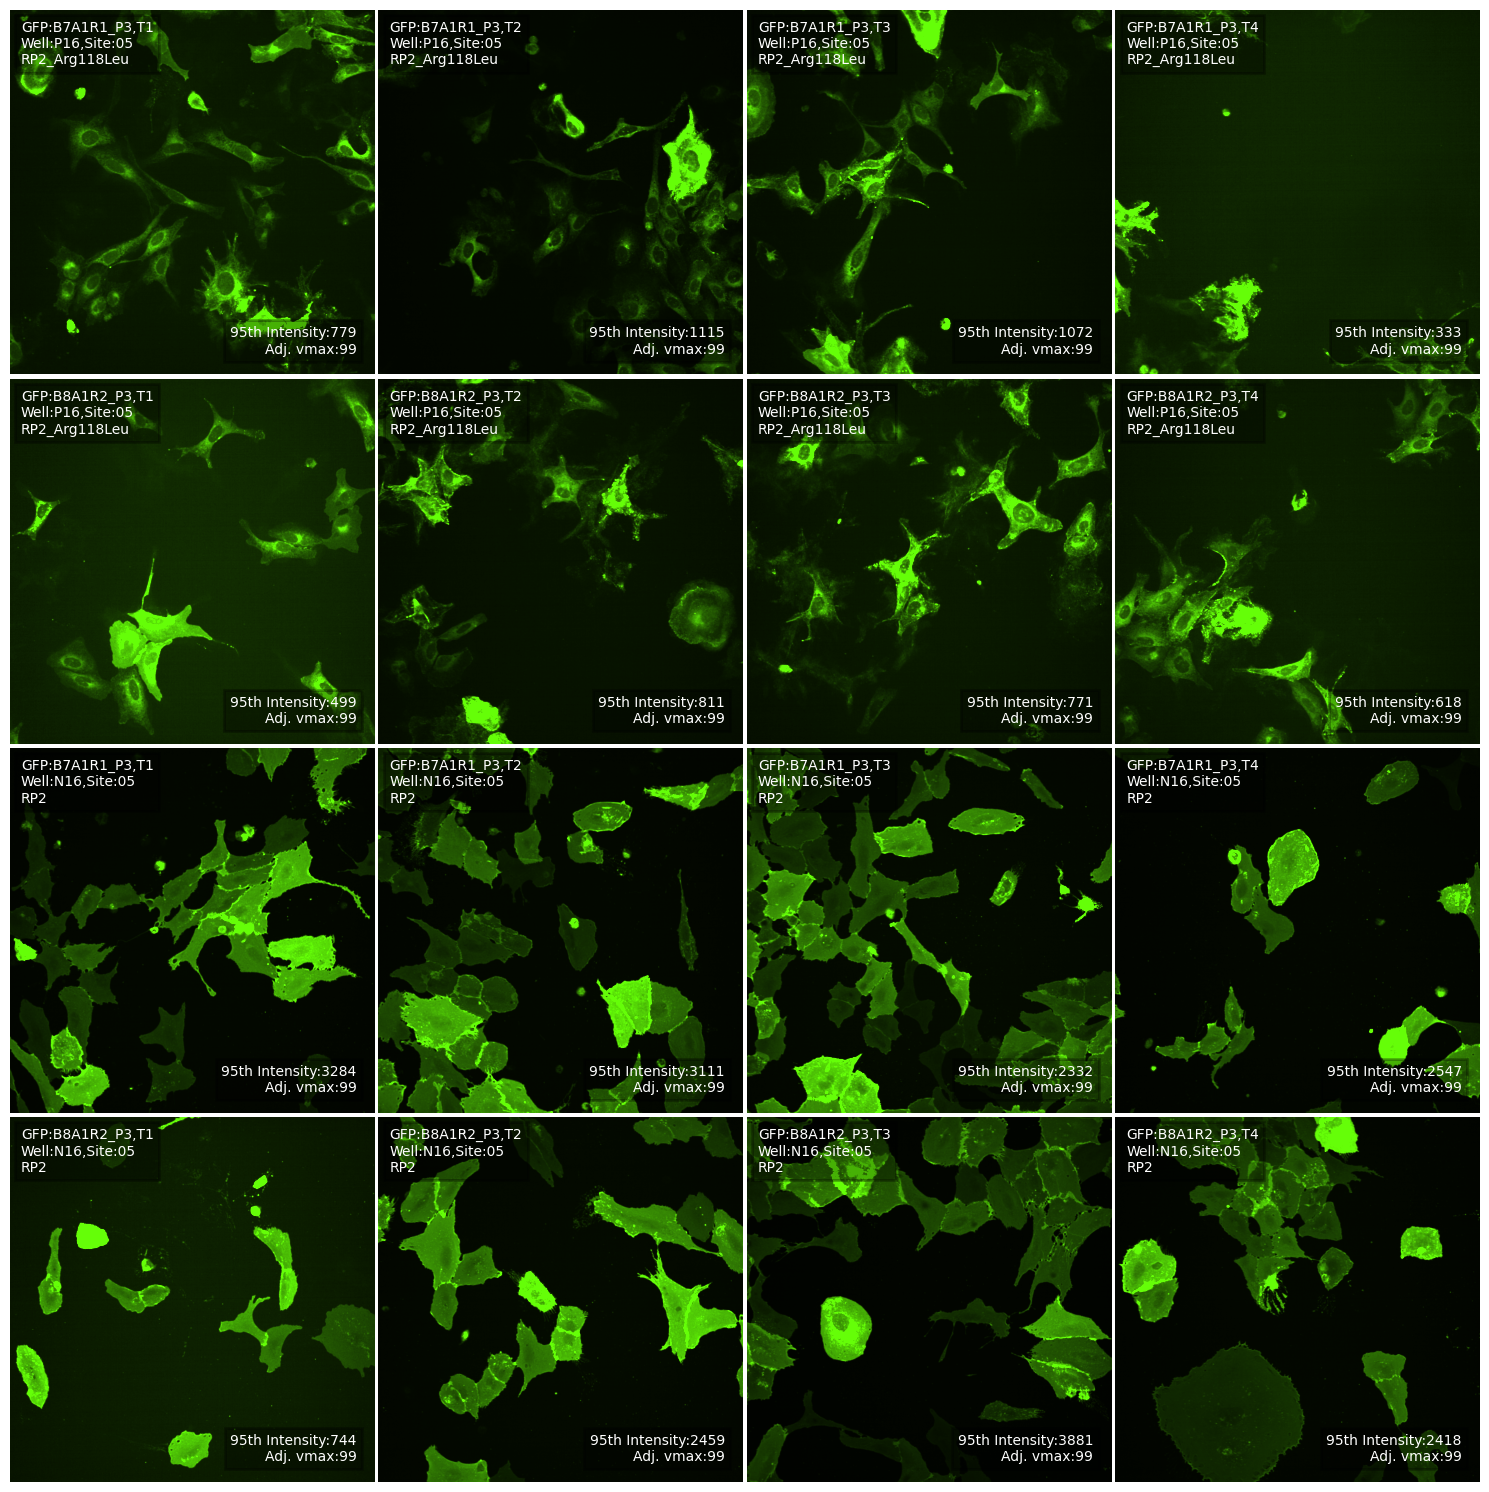

In [16]:
plot_allele(meta_data, "RP2_Arg118Leu", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)

In [17]:
# plot_allele(meta_data, "SMAD1_Val3Ala", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.999, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_imgs_dir)
# plot_allele(meta_data, "SMAD1_Val3Ala", "AGP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_imgs_dir)
# plot_allele(meta_data, "SMAD1_Val3Ala", "Mito", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_imgs_dir)
# plot_allele(meta_data, "SMAD1_Val3Ala", "DAPI", auroc_df=local_wtvar, site="05", max_intensity=0.999, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_imgs_dir)

In [8]:
# variant_list = ['ACSF3_Met266Val',
#  'ACSF3_Gly119Asp',
#  'ACSF3_Arg558Trp',
#  'ACSF3_Arg471Trp',
#  'ACSF3_Pro243Leu',
#  'ACSF3_Asp457Asn',
#  'ACSF3_Thr358Ile']

# variant_list = ['PLA2G6_Thr585Ile',
#             'PLA2G6_Leu481Gln',
#             'PLA2G6_Arg600Gln',
#             'PLA2G6_Val310Glu',
#             'PLA2G6_Glu567Lys',
#             'PLA2G6_Arg538Cys']

# variant_list = ['IL2RG_Tyr89Cys', 'KCTD7_Asn273Ile', 'AGXT_Ile279Met',
#        'ASNS_Ala6Glu', 'ACSF3_Ser431Tyr', 'HBD_Gly26Asp',
#        'SFTPC_Leu188Gln', 'SH3BP2_Gly420Glu', 'DIABLO_Ser126Leu',
#        'PLP1_Ser135Phe', 'DES_Ala337Pro', 'SFTPC_Leu194Pro',
#        'EIF2B4_Ala228Val', 'TH_Pro121Leu', 'EFHC1_Asp253Tyr',
#        'FBP1_Phe194Ser', 'POMT1_Trp560Cys', 'AIPL1_Met79Thr',
#        'EFHC1_Cys259Tyr', 'AGXT_Ile202Asn', 'SMAD1_Val3Ala',
#        'RP2_Cys86Tyr', 'EFHC1_Met448Thr', 'SFTPC_Ile73Thr',
#        'SMN2_Gly287Arg', 'EFHC1_Asp210Asn', 'PKP2_Ala526Thr',
#        'RP2_Leu253Arg', 'PLP1_Ile152Thr', 'PMP22_Asp37Val',
#        'PLP1_Gly186Cys', 'TAT_Arg433Trp', 'TTPA_Gly246Arg',
#        'DCX_Ser129Leu', 'COMP_Asn523Lys', 'FXN_Trp173Gly']

# for variant in tqdm(variant_list):
#     plot_allele(meta_data, variant, "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.999, display=False, imgs_dir=tiff_imgs_dir, output_dir=out_imgs_dir)

## Plot Cells

In [7]:
out_cells_dir = "../snakemake_pipeline/outputs/visualize_cells"

In [8]:
# Filter thresholds
min_area_ratio = 0.15
max_area_ratio = 0.3
min_center = 50
max_center = 1030
num_mad = 5
min_cells = 250

batch_profiles = {}
for batch_id in batches:
    imagecsv_dir = f"{CP_GALLERY_DIR}/image_csv/cpg0020-varchamp/broad/workspace/assaydev/{batch_id}"
    prof_path = f"../snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles.parquet"
    # Get metadata
    profiles = pl.scan_parquet(prof_path).select(
        ["Metadata_well_position", "Metadata_plate_map_name", "Metadata_ImageNumber", "Metadata_ObjectNumber",
        "Metadata_symbol", "Metadata_gene_allele", "Metadata_control_type", "Metadata_Plate",
        "Nuclei_AreaShape_Area", "Cells_AreaShape_Area", "Nuclei_AreaShape_Center_X", "Nuclei_AreaShape_Center_Y",
        "Cells_AreaShape_BoundingBoxMaximum_X", "Cells_AreaShape_BoundingBoxMaximum_Y", "Cells_AreaShape_BoundingBoxMinimum_X",
        "Cells_AreaShape_BoundingBoxMinimum_Y",	"Cells_AreaShape_Center_X",	"Cells_AreaShape_Center_Y",
        "Cells_Intensity_MeanIntensity_GFP", "Cells_Intensity_MedianIntensity_GFP", "Cells_Intensity_IntegratedIntensity_GFP"],
    ).collect()

    # Filter based on cell to nucleus area
    profiles = profiles.with_columns(
                    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area"),
                    pl.concat_str([
                        "Metadata_Plate", "Metadata_well_position", "Metadata_ImageNumber", "Metadata_ObjectNumber",
                        ], separator="_").alias("Metadata_CellID"),
            ).filter((pl.col("Nucleus_Cell_Area") > min_area_ratio) & (pl.col("Nucleus_Cell_Area") < max_area_ratio))

    # Filter cells too close to image edge
    profiles = profiles.filter(
        ((pl.col("Nuclei_AreaShape_Center_X") > min_center) & (pl.col("Nuclei_AreaShape_Center_X") < max_center) &
        (pl.col("Nuclei_AreaShape_Center_Y") > min_center) & (pl.col("Nuclei_AreaShape_Center_Y") < max_center)),
    )

    # Calculate mean, median and mad of gfp intensity for each allele
    ## mean
    means = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Cells_Intensity_MeanIntensity_GFP").mean().alias("WellIntensityMean"),
    )
    profiles = profiles.join(means, on=["Metadata_Plate", "Metadata_well_position"])
    ## median
    medians = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Cells_Intensity_MedianIntensity_GFP").median().alias("WellIntensityMedian"),
    )
    profiles = profiles.join(medians, on=["Metadata_Plate", "Metadata_well_position"])
    ## mad
    profiles = profiles.with_columns(
        (pl.col("Cells_Intensity_MedianIntensity_GFP") - pl.col("WellIntensityMedian")).abs().alias("Abs_dev"),
    )
    mad = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Abs_dev").median().alias("Intensity_MAD"),
    )
    profiles = profiles.join(mad, on=["Metadata_Plate", "Metadata_well_position"])

    # Threshold is 5X
    # Used to be median well intensity + 5*mad implemented by Jess
    # Switching to mean well intensity + 5*mad implemented by Runxi
    # profiles = profiles.with_columns(
    #     (pl.col("WellIntensityMedian") + num_mad*pl.col("Intensity_MAD")).alias("Intensity_upper_threshold"), ## pl.col("WellIntensityMedian")
    #     (pl.col("WellIntensityMedian") - num_mad*pl.col("Intensity_MAD")).alias("Intensity_lower_threshold"), ## pl.col("WellIntensityMedian")
    # )
    # ## Filter by intensity MAD
    # profiles = profiles.filter(
    #     pl.col("Cells_Intensity_MeanIntensity_GFP") <= pl.col("Intensity_upper_threshold"),
    # ).filter(
    #     pl.col("Cells_Intensity_MeanIntensity_GFP") >= pl.col("Intensity_lower_threshold"),
    # )

    # Filter out alleles with fewer than 250 cells
    # keep_alleles = profiles.group_by("Metadata_gene_allele").count().filter(
    #     pl.col("count") >= min_cells,
    #     ).select("Metadata_gene_allele").to_series().to_list()
    # profiles = profiles.filter(pl.col("Metadata_gene_allele").is_in(keep_alleles))

    # add full crop coordinates
    profiles = profiles.with_columns(
        (pl.col("Nuclei_AreaShape_Center_X") - 50).alias("x_low").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_X") + 50).alias("x_high").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_Y") - 50).alias("y_low").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_Y") + 50).alias("y_high").round().cast(pl.Int16),
    )

    # Read in all Image.csv to get ImageNumber:SiteNumber mapping and paths
    image_dat = []
    icf = os.listdir(imagecsv_dir)
    for fp in tqdm(icf):
        plate, well = fp.split("-")
        image_dat.append(pl.read_csv(f"{imagecsv_dir}/{fp}/Image.csv").select(
            [
                "ImageNumber",
                "Metadata_Site",
                "PathName_OrigDNA",
                "FileName_OrigDNA",
                "FileName_OrigGFP",
                ],
            ).with_columns(
            pl.lit(plate).alias("Metadata_Plate"),
            pl.lit(well).alias("Metadata_well_position"),
            ))
    image_dat = pl.concat(image_dat).rename({"ImageNumber": "Metadata_ImageNumber"})

    # Create useful filepaths
    image_dat = image_dat.with_columns(
        pl.col("PathName_OrigDNA").str.replace(".*cpg0020-varchamp/", "").alias("Path_root"),
    )

    image_dat = image_dat.drop([
        "PathName_OrigDNA",
        "FileName_OrigDNA",
        "FileName_OrigGFP",
        "Path_root",
    ])

    # Append to profiles
    profiles = profiles.join(image_dat, on = ["Metadata_Plate", "Metadata_well_position", "Metadata_ImageNumber"])

    # Sort by allele, then image number
    profiles = profiles.with_columns(
        pl.concat_str(["Metadata_Plate", "Metadata_well_position", "Metadata_Site"], separator="_").alias(
            "Metadata_SiteID"),
        pl.col("Metadata_gene_allele").str.replace("_", "-").alias("Protein_label"),
    )
    profiles = profiles.sort(["Protein_label", "Metadata_SiteID"])
    alleles = profiles.select("Protein_label").to_series().unique().to_list()

    batch_profiles[batch_id] = profiles

100%|██████████| 7665/7665 [00:05<00:00, 1322.95it/s]


In [9]:
def crop_allele(allele: str, profile_df: pl.DataFrame, meta_plate: str, rep: str, site: str="5") -> None:
    """Crop images and save metadata as numpy arrays for one allele.

    Parameters
    ----------
    allele : String
        Name of allele to process
    profile_df : String
        Dataframe with pathname and cell coordinates
    img_dir : String
        Directory where all images are stored
    out_dir : String
        Directory where numpy arrays should be saved
    """
    allele_df = profile_df.filter(
        (pl.col("Metadata_gene_allele")==allele) &
        (pl.col("Metadata_Site")==int(site)) &
        (pl.col("Metadata_plate_map_name")==meta_plate) &
        (pl.col("Metadata_Plate").str.contains(rep))
    )
    return allele_df

allele_df = crop_allele("SMAD1", batch_profiles["2024_01_23_Batch_7"], "B7A1R1_P4", "T1", site="5")
allele_df

shape: (26, 34)
┌────────────┬────────────┬───────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ Metadata_w ┆ Metadata_p ┆ Metadata_ ┆ Metadata_ ┆ … ┆ y_high ┆ Metadata_ ┆ Metadata_ ┆ Protein_l │
│ ell_positi ┆ late_map_n ┆ ImageNumb ┆ ObjectNum ┆   ┆ ---    ┆ Site      ┆ SiteID    ┆ abel      │
│ on         ┆ ame        ┆ er        ┆ ber       ┆   ┆ i16    ┆ ---       ┆ ---       ┆ ---       │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆        ┆ i64       ┆ str       ┆ str       │
│ str        ┆ str        ┆ i64       ┆ i64       ┆   ┆        ┆           ┆           ┆           │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ A05        ┆ B7A1R1_P4  ┆ 41        ┆ 13        ┆ … ┆ 560    ┆ 5         ┆ 2024_01_1 ┆ SMAD1     │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 9_B7A1R1_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ P4T1_A05_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 5         ┆           │
│ A05        ┆ B7A1R1_P4  ┆ 41        ┆ 14        ┆ … ┆ 594    ┆ 5         ┆ 2024_01_1 ┆ SMAD1     │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 9_B7A1R1_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ P4T1_A05_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 5         ┆           │
│ A05        ┆ B7A1R1_P4  ┆ 41        ┆ 19        ┆ … ┆ 714    ┆ 5         ┆ 2024_01_1 ┆ SMAD1     │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 9_B7A1R1_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ P4T1_A05_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 5         ┆           │
│ A05        ┆ B7A1R1_P4  ┆ 41        ┆ 22        ┆ … ┆ 734    ┆ 5         ┆ 2024_01_1 ┆ SMAD1     │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 9_B7A1R1_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ P4T1_A05_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 5         ┆           │
│ A05        ┆ B7A1R1_P4  ┆ 41        ┆ 30        ┆ … ┆ 862    ┆ 5         ┆ 2024_01_1 ┆ SMAD1     │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 9_B7A1R1_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ P4T1_A05_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 5         ┆           │
│ …          ┆ …          ┆ …         ┆ …         ┆ … ┆ …      ┆ …         ┆ …         ┆ …         │
│ A05        ┆ B7A1R1_P4  ┆ 41        ┆ 34        ┆ … ┆ 927    ┆ 5         ┆ 2024_01_1 ┆ SMAD1     │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 9_B7A1R1_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ P4T1_A05_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 5         ┆           │
│ A05        ┆ B7A1R1_P4  ┆ 41        ┆ 24        ┆ … ┆ 755    ┆ 5         ┆ 2024_01_1 ┆ SMAD1     │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 9_B7A1R1_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ P4T1_A05_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 5         ┆           │
│ A05        ┆ B7A1R1_P4  ┆ 41        ┆ 3         ┆ … ┆ 106    ┆ 5         ┆ 2024_01_1 ┆ SMAD1     │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ 9_B7A1R1_ ┆           │
│            ┆            ┆           ┆           ┆   ┆        ┆           ┆ P4T1_A05_ ┆           │
│            ┆            ┆           ┆      

In [10]:
# Compute distances from edges and find the most centered well
def compute_distance_cell(row, col, edge=1080):
    return min(row - 1, edge - row, col - 1, edge - col)  # Distance from nearest edge
    

def plot_allele_cell(pm, variant, sel_channel, auroc_df, site="05", max_intensity=0.99, display=False, imgs_dir=tiff_imgs_dir, output_dir=out_imgs_dir):
    cmap = channel_to_cmap(sel_channel)
    channel = channel_dict[sel_channel]
    auroc = auroc_df.filter(pl.col("allele_0")==variant)["AUROC_mean"].mean()

    # if os.path.exists(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}_cells.png")):
    #     print(f"Image for {variant} already exists.")
        # return None

    ## get the number of wells/images per allele
    wt = variant.split("_")[0]
    wt_wells = pm.filter(pl.col("gene_allele") == wt).select("imaging_well").to_pandas().values.flatten()
    var_wells = pm.filter(pl.col("gene_allele") == variant).select("imaging_well").to_pandas().values.flatten()
    plate_map = pm.filter(pl.col("gene_allele") == variant).select("plate_map_name").to_pandas().values.flatten()

    if len(wt_wells) > 1:
        # Get coordinates of wells
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in wt_wells])]
        # Sort wells by max distance from edges (descending)
        wt_wells = [max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]]

    pm_var = pm.filter((pl.col("imaging_well").is_in(np.concatenate([wt_wells, var_wells])))&(pl.col("plate_map_name").is_in(plate_map))).sort("control_type")
    # print(pm_var)
    plt.clf()

    fig, axes = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
    # fig2, axes2 = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
    for wt_var, pm_row in enumerate(pm_var.iter_rows(named=True)):
        # print(pm_row)
        if pm_row["control_type"] == "allele":
            well = var_wells[0]
            allele = variant
        else:
            well = wt_wells[0]
            allele = wt

        for i in range(8):
            plot_idx = i+wt_var*4*2
            if i < 4:
                sel_plate = pm_row["imaging_plate_R1"]
            else:
                sel_plate = pm_row["imaging_plate_R2"]
                
            batch = batch_dict[sel_plate.split("_")[0]]
            batch_img_dir = f'{imgs_dir}/{batch}/images'
            letter = well[0]
            row = letter_dict[letter]
            col = well[1:3]
            
            # print(i, allele, well)
            plate_img_dir = plate_dict[sel_plate][f"T{i%4+1}"]
            img_file = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"
            img = imread(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}", as_gray=True)
            print(np.percentile(img, 99) / np.median(img), np.percentile(img, 99) / np.percentile(img, 25))

            ## Full images
            # axes2.flatten()[plot_idx].imshow(img, vmin=0, vmax=np.percentile(img, max_intensity*100), cmap=cmap)
            # plot_label = f"{sel_channel}:{sel_plate},T{i%4+1}\nWell:{well},Site:{site}\n{allele}"
            # axes2.flatten()[plot_idx].text(0.03, 0.97, plot_label, color='white', fontsize=10,
            #         verticalalignment='top', horizontalalignment='left', transform=axes2.flatten()[plot_idx].transAxes,
            #         bbox=dict(facecolor='black', alpha=0.3, linewidth=2))

            ## Draw cells
            cell_allele_coord_df = crop_allele(allele, batch_profiles[batch], sel_plate, f"T{i%4+1}", site=site[-1]) # "2024_01_19_B7A1R1_P4T1"
            cell_allele_coord_df = cell_allele_coord_df.with_columns(
                pl.struct("Cells_AreaShape_Center_X", "Cells_AreaShape_Center_Y") # 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y'
                .map_elements(lambda x: compute_distance_cell(x['Cells_AreaShape_Center_X'], x['Cells_AreaShape_Center_Y']), return_dtype=pl.Float32).cast(pl.Int16)
                .alias('dist2edge')
            ).sort("dist2edge", descending=True)
            
            if cell_allele_coord_df.is_empty():
                axes.flatten()[plot_idx].set_visible(False)
                print(i, allele, well)
                continue
            else:
                plot_yet = 0
                for cell_idx, cell_row in enumerate(cell_allele_coord_df.head().iter_rows(named=True)):
                    if plot_yet:
                        break
                    x, y = int(cell_row["Nuclei_AreaShape_Center_X"]), int(cell_row["Nuclei_AreaShape_Center_Y"])
                    # x, y = int(cell_allele_coord_df["Cells_AreaShape_Center_X"].to_numpy()[0]), int(cell_allele_coord_df["Cells_AreaShape_Center_Y"].to_numpy()[0])
                    ## flip the x and y for visualization
                    img_sub = img[
                        y-128:y+128, x-128:x+128
                    ]
                    if img_sub.shape[0] == 0 or img_sub.shape[1] == 0 or np.percentile(img_sub, 90) <= np.median(img):
                        continue
                    axes.flatten()[plot_idx].imshow(img_sub, vmin=0, vmax=np.percentile(img_sub, max_intensity*100), cmap=cmap)  ## np.percentile(img_sub, max_intensity*100)
                    plot_label = f"{sel_channel}:{sel_plate},T{i%4+1}\nWell:{well},Site:{site}\n{allele}"
                    axes.flatten()[plot_idx].text(0.03, 0.97, plot_label, color='white', fontsize=10,
                            verticalalignment='top', horizontalalignment='left', transform=axes.flatten()[plot_idx].transAxes,
                            bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
                    int_95 = str(int(round(np.percentile(img_sub, 95))))
                    axes.flatten()[plot_idx].text(0.95, 0.05, f"95th Intensity:{int_95}", color='white', fontsize=10,
                                verticalalignment='bottom', horizontalalignment='right', transform=axes.flatten()[plot_idx].transAxes,
                                bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
                    axes.flatten()[plot_idx].axis("off")
                    plot_yet = 1

                # axes.flatten()[plot_idx].set_visible(False)
                # x_min, y_min, x_max, y_max = int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMinimum_X"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMinimum_Y"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMaximum_X"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMaximum_Y"].to_numpy()[0])
                # print(x_min, y_min, x_max, y_max)
            #     for cell_idx, cell_row in enumerate(cell_allele_coord_df.head().iter_rows(named=True)):
            #         x_nuc, y_nuc = int(cell_row["Nuclei_AreaShape_Center_X"]), int(cell_row["Nuclei_AreaShape_Center_Y"])
            #         # Create a Rectangle patch
            #         rect = patches.Rectangle((x_nuc-5, y_nuc-5), 10, 10, linewidth=2, edgecolor='red', facecolor='none')
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         rect = patches.Rectangle((x-128, y-128), 256, 256, linewidth=2, edgecolor='red', facecolor='none')
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         # x_min, y_min, x_max, y_max = int(cell_row["Cells_AreaShape_BoundingBoxMinimum_X"]), int(cell_row["Cells_AreaShape_BoundingBoxMinimum_Y"]), \
            #         #                              int(cell_row["Cells_AreaShape_BoundingBoxMaximum_X"]), int(cell_row["Cells_AreaShape_BoundingBoxMaximum_Y"])
            #         # print(x_min, y_min, x_max, y_max)
            #         # rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='red', facecolor='none')
            #         # Add the patch to the Axes
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         break
            # int_95 = str(int(round(np.percentile(img, 95))))
            # axes2.flatten()[plot_idx].axhline(y=img.shape[1]//2, color='red', linestyle='--', linewidth=1)
            # axes2.flatten()[plot_idx].axvline(x=img.shape[0]//2, color='red', linestyle='--', linewidth=1)
            # axes2.flatten()[plot_idx].text(0.95, 0.05, f"95th Percentile\nIntensity:{int_95}", color='white', fontsize=12,
            #                verticalalignment='bottom', horizontalalignment='right', transform=axes2.flatten()[plot_idx].transAxes)
            # axes2.flatten()[plot_idx].axis("off")
            
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.01, hspace=-0.2, top=.99)

    # fig2.tight_layout()
    # fig2.subplots_adjust(wspace=.01, hspace=-0.2, top=.99)
    
    if display:
        plt.show()

    if output_dir:
        fig.savefig(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}_cells.png"), dpi=400, bbox_inches='tight')
        plt.close(fig)

# plot_allele_cell(meta_data, "SMAD1_Val3Ala", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.95, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)

In [ ]:
plot_allele_cell(meta_data, "SMAD1_Val3Ala", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)
plot_allele_cell(meta_data, "SMAD1_Val3Ala", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)

17.5875 19.678321678321677
8.884615384615385 9.971223021582734
10.2375 11.454545454545455
10.302469135802468 11.431506849315069
12.710526315789474 14.0
25.316770186335404 28.704225352112676
16.273885350318473 17.992957746478872
5.230263157894737 5.802919708029197
1.5031847133757963 1.673758865248227
1.8387096774193548 2.0357142857142856
1.303225806451613 1.4428571428571428
2.484472049689441 2.7586206896551726
2.4266666666666667 2.716417910447761
1.9735099337748345 2.1911764705882355
5 SMN2 C17
2.185430463576159 2.426470588235294
1.2348993288590604 1.373134328358209
7 SMN2 C17


<Figure size 640x480 with 0 Axes>

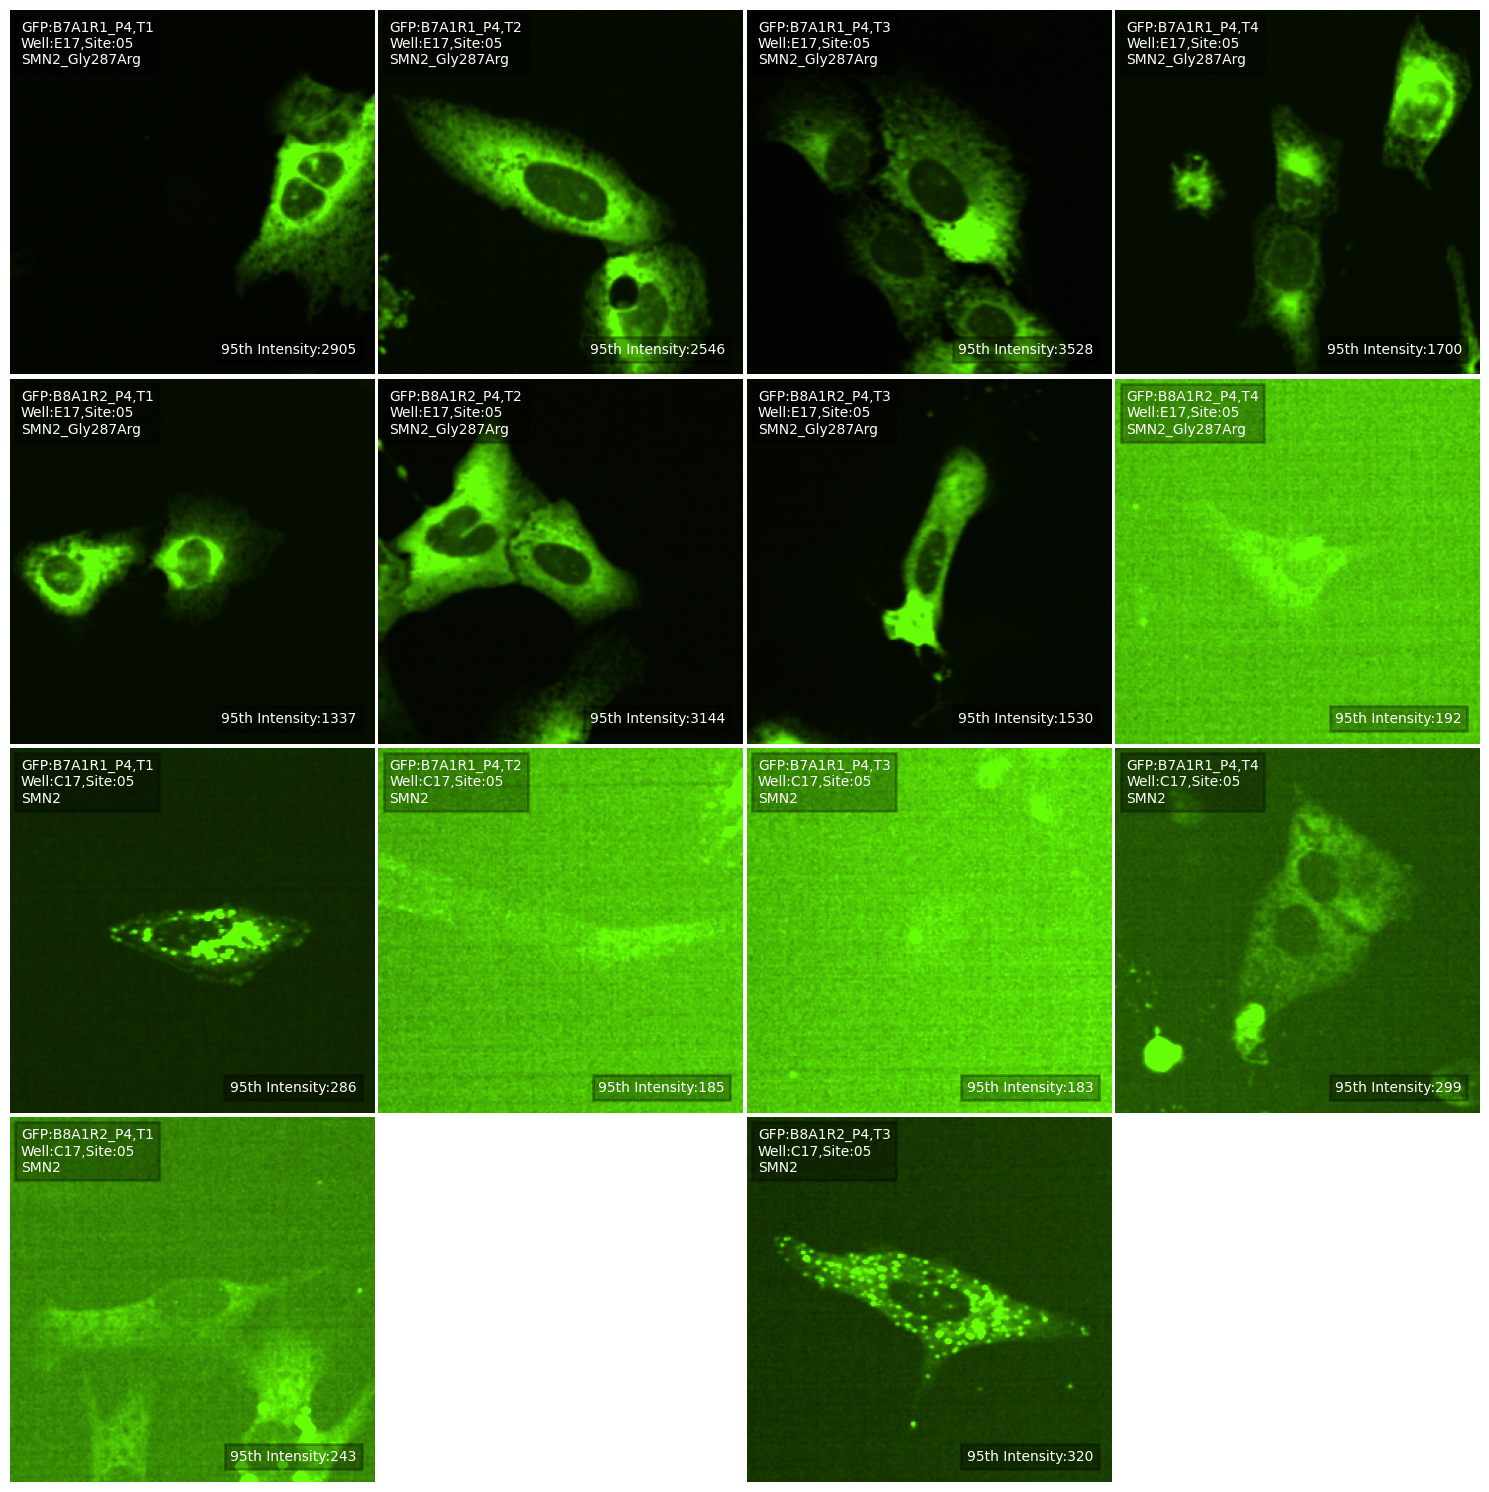

In [21]:
plot_allele_cell(meta_data, "SMN2_Gly287Arg", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)

9.481283422459892 10.877300613496933
23.5 27.54140127388535
13.62365168539331 15.44592356687904
7.2075471698113205 7.8493150684931505
6.2592592592592595 7.041666666666667
12.952941176470588 14.392156862745098
5 RP2_Arg118Leu P16
10.08235294117647 11.426666666666666
6 RP2_Arg118Leu P16
8.603658536585366 9.598639455782314
27.255681818181817 30.75
26.313186813186814 30.11949685534591
19.411167512690355 23.317073170731707
31.83542682926835 35.76034246575349
8.452229299363058 9.478571428571428
22.63855421686747 25.564625850340136
5 RP2 N16
38.48050279329614 44.43877419354845
29.31360946745562 34.16551724137931


<Figure size 640x480 with 0 Axes>

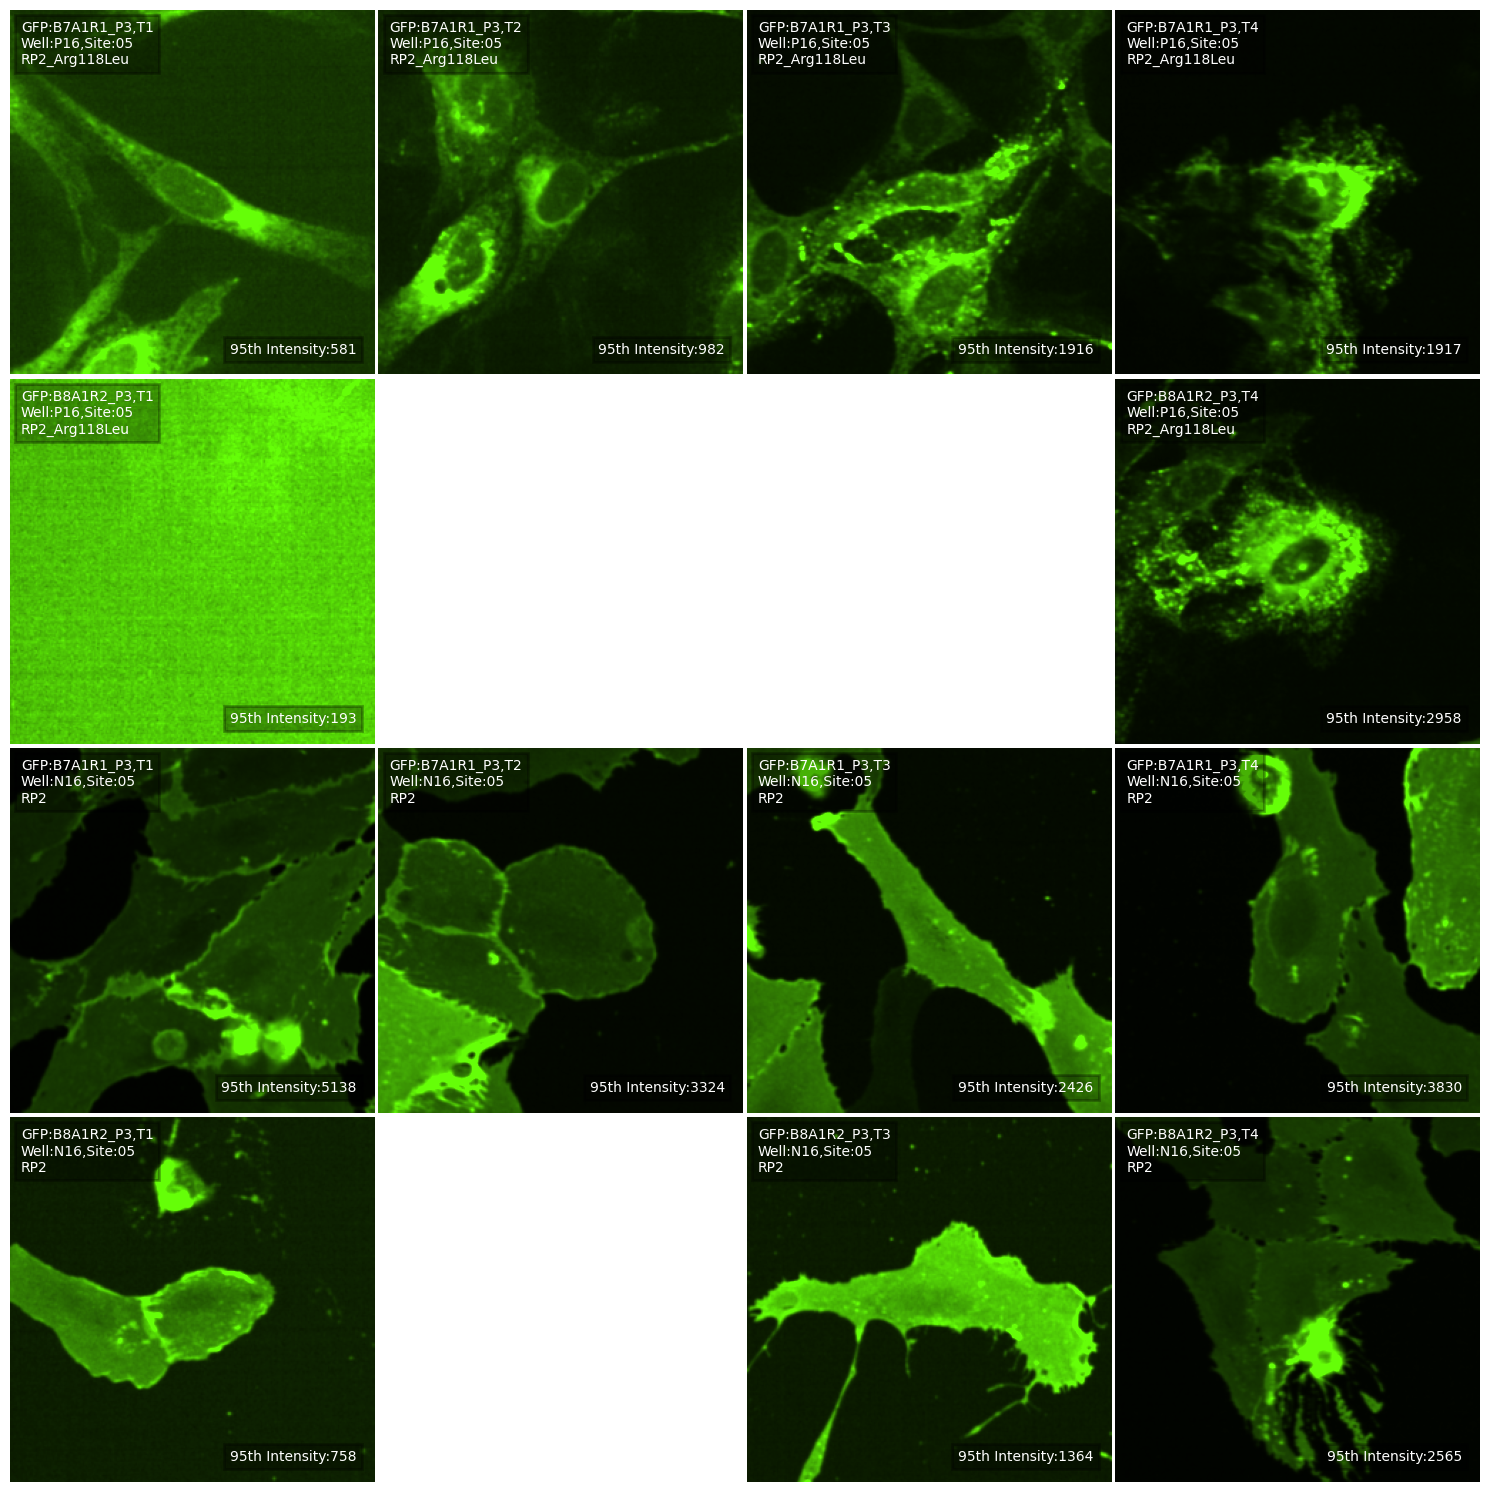

In [15]:
plot_allele_cell(meta_data, "RP2_Arg118Leu", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)

3.45 3.86013986013986
3.3227848101265822 3.6971830985915495
4.687898089171974 5.294964028776978
3.930379746835443 4.404255319148936
3.5064935064935066 3.9130434782608696
4 ACSF3_Asp457Asn A03
2.4901960784313726 2.781021897810219
2.6554054054054053 2.954887218045113
2.108108108108108 2.345864661654135
7.156626506024097 7.973154362416107
5.592814371257485 6.35374149659864
5.87037037037037 6.604166666666667
4.0 4.4822695035460995
3.3870967741935485 3.75
3.9473684210526314 4.37956204379562
2.8503401360544216 3.1742424242424243
2.7039473684210527 3.0


<Figure size 640x480 with 0 Axes>

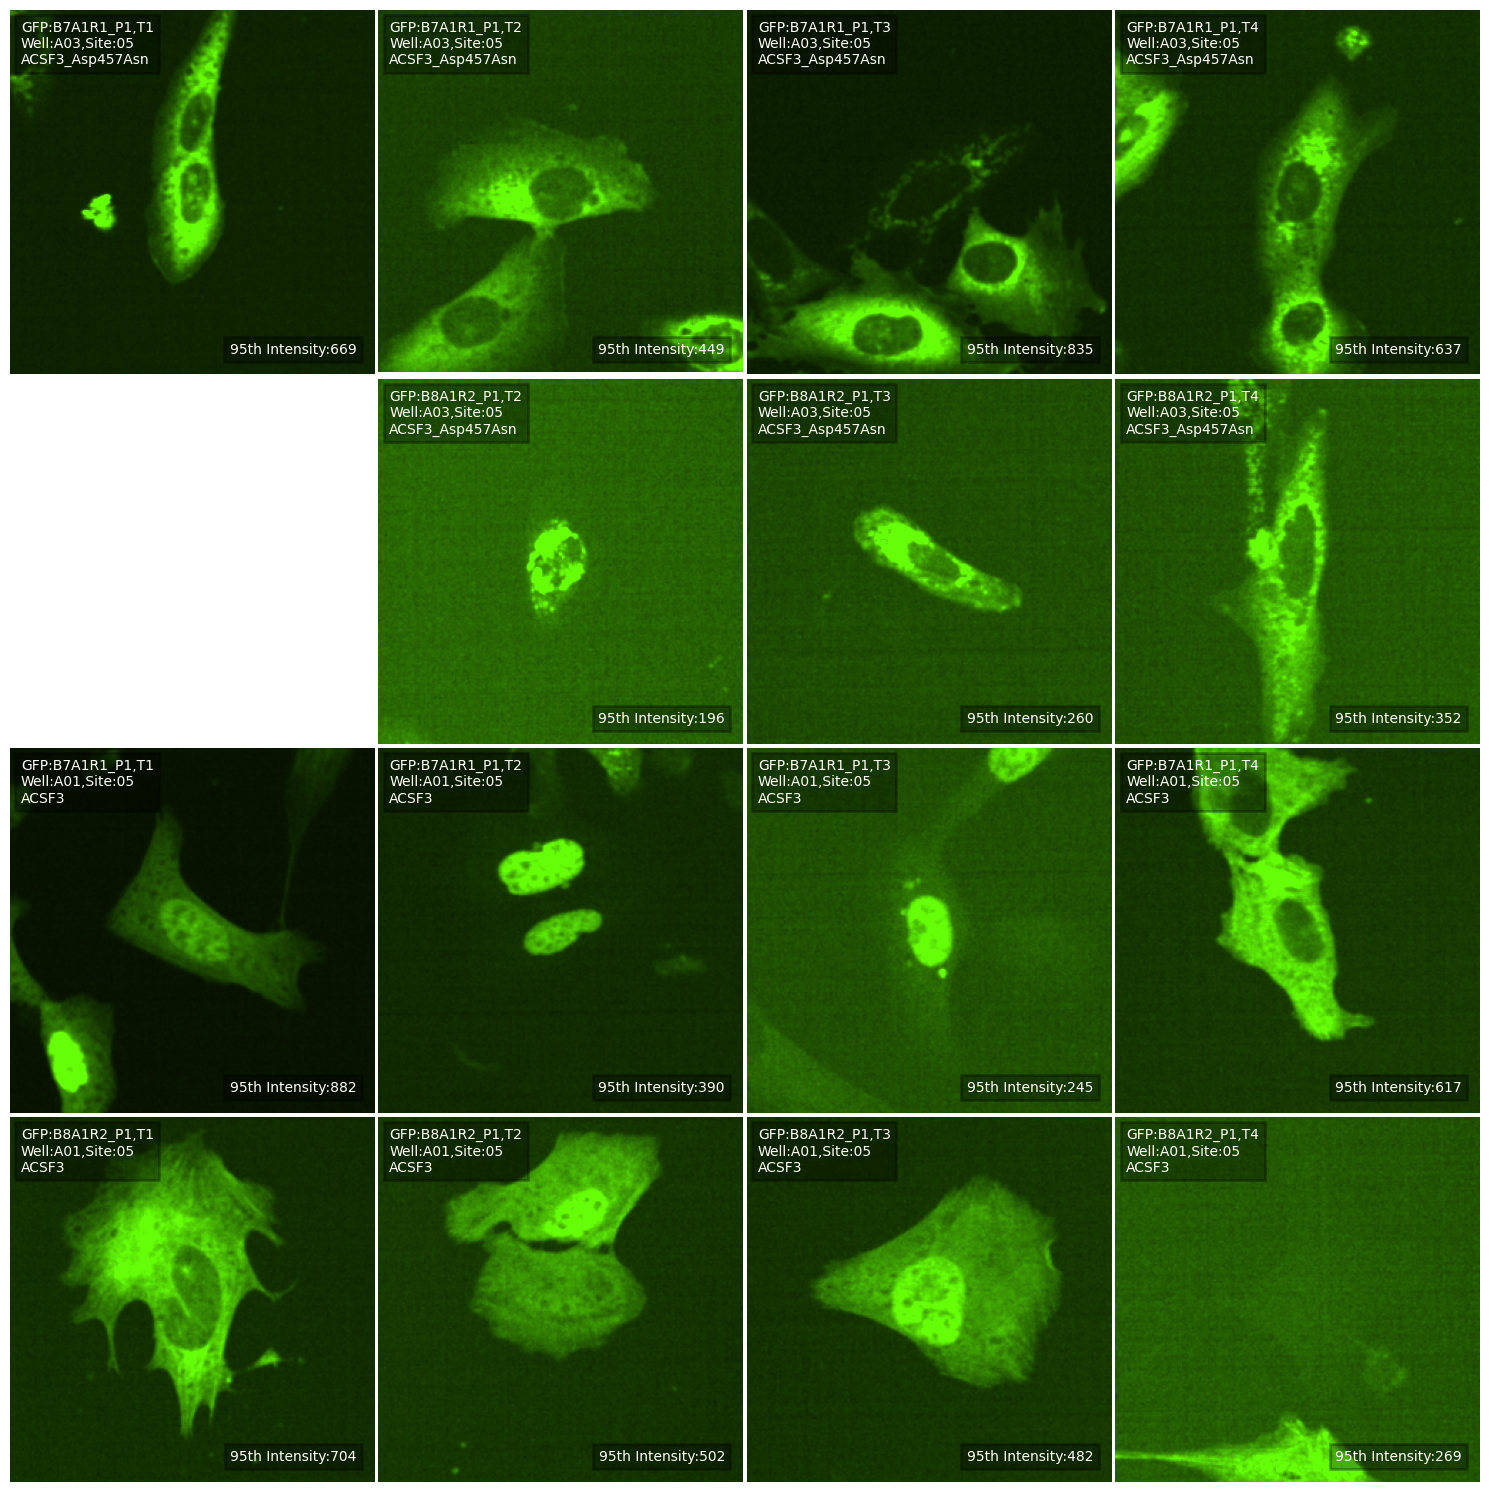

In [40]:
plt.clf()
plot_allele_cell(meta_data, "ACSF3_Asp457Asn", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)

In [12]:
# plt.clf()
# plot_allele_cell(meta_data, "PLA2G6_Val310Glu", "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=True, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)

In [ ]:
# variant_list = ['RP2_Cys86Tyr', 'RP2_Leu253Arg', 'HBD_Gly26Asp', 'EFHC1_Asp253Tyr',
#        'PKP2_Ala526Thr', 'PMP22_Asp37Val', 'SMAD1_Val3Ala',
#        'DCX_Ser129Leu', 'TTPA_Gly246Arg', 'FXN_Trp173Gly',
#        'EFHC1_Cys259Tyr', 'IL2RG_Tyr89Cys', 'SFTPC_Ile73Thr',
#        'PLP1_Gly186Cys', 'ASNS_Ala6Glu', 'EFHC1_Met448Thr',
#        'SH3BP2_Gly420Glu', 'KCTD7_Asn273Ile', 'EIF2B4_Ala228Val',
#        'ACSF3_Ser431Tyr', 'SFTPC_Leu188Gln', 'SMN2_Gly287Arg',
#        'POMT1_Trp560Cys', 'SFTPC_Leu194Pro', 'PLP1_Ile152Thr',
#        'EFHC1_Asp210Asn', 'FBP1_Phe194Ser', 'TAT_Arg433Trp',
#        'DES_Ala337Pro', 'COMP_Asn523Lys', 'AIPL1_Met79Thr',
#        'PLP1_Ser135Phe', 'DIABLO_Ser126Leu', 'AGXT_Ile202Asn']

# variant_list_2 = ['ACSF3_Met266Val',
#  'ACSF3_Gly119Asp',
#  'ACSF3_Arg558Trp',
#  'ACSF3_Arg471Trp',
#  'ACSF3_Pro243Leu',
#  'ACSF3_Asp457Asn',
#  'ACSF3_Thr358Ile']

variant_list_3 = ['PLA2G6_Thr585Ile',
            'PLA2G6_Leu481Gln',
            'PLA2G6_Arg600Gln',
            'PLA2G6_Val310Glu',
            'PLA2G6_Glu567Lys',
            'PLA2G6_Arg538Cys']

# variant_list += variant_list_2 + variant_list_3
# for variant in tqdm(variant_list_3):
#     plot_allele_cell(meta_data, variant, "GFP", auroc_df=local_wtvar, site="05", max_intensity=0.99, display=False, imgs_dir=tiff_imgs_dir, output_dir=out_cells_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Image for PLA2G6_Thr585Ile already exists.
5 PLA2G6_Thr585Ile N13
5 PLA2G6 D13


 17%|█▋        | 1/6 [00:04<00:20,  4.19s/it]

Image for PLA2G6_Leu481Gln already exists.
3 PLA2G6_Leu481Gln P13
5 PLA2G6_Leu481Gln P13
7 PLA2G6_Leu481Gln P13
5 PLA2G6 D13


 33%|███▎      | 2/6 [00:07<00:15,  3.88s/it]

Image for PLA2G6_Arg600Gln already exists.
5 PLA2G6_Arg600Gln J13
5 PLA2G6 D13


 50%|█████     | 3/6 [00:11<00:11,  3.96s/it]

Image for PLA2G6_Val310Glu already exists.
3 PLA2G6_Val310Glu B15
5 PLA2G6_Val310Glu B15
6 PLA2G6_Val310Glu B15
5 PLA2G6 D13


 67%|██████▋   | 4/6 [00:15<00:07,  3.85s/it]

Image for PLA2G6_Glu567Lys already exists.
5 PLA2G6_Glu567Lys F13
7 PLA2G6_Glu567Lys F13
5 PLA2G6 D13


 83%|████████▎ | 5/6 [00:19<00:03,  3.87s/it]

Image for PLA2G6_Arg538Cys already exists.
3 PLA2G6_Arg538Cys H13
5 PLA2G6_Arg538Cys H13
5 PLA2G6 D13


100%|██████████| 6/6 [00:23<00:00,  3.89s/it]
